# Build model

This notebook is used to build a model to classify the data from the [Quick Draw!](https://github.com/googlecreativelab/quickdraw-dataset) dataset. The creation of the cutsom dataset is explained in the **dataset_create.ipynb** notebook. The model is built using the PyTorch library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


The custom `DoodleDataset` is created using the PyTorch library. The dataset is created by inheriting the `torch.utils.data.Dataset` class and overriding the `__len__` and `__getitem__` methods. The `__len__` method returns the length of the dataset and the `__getitem__` method returns the data and the label of the dataset. In the `.npy` file, each image is stored as a 784-dimensional vector and the 785th element is the label of the image. In the `__init__` method, the path to the `.npy` file is passed and the data is reshaped to a 28x28 image and converted to `uint8` type to be able to use PyTorch transforms and the label values are stored in the `label` attribute, kept as `int32`.

In [2]:
class DoodleDataset(Dataset):
    def __init__(self, path=None, transform=None):
        if path is not None:
            self.data = np.load(path)
            self.labels = self.data[:, -1]
            self.data = self.data[:, :-1]

            #unsqueeze the data
            self.data = self.data.reshape(-1, 28, 28)
            
            #convert data to np.uint8
            self.data = self.data.astype(np.uint8)
        else:
            raise ValueError('Path is required')
        
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

The train, test and validation datasets are created, as well as the dataloaders. The `batch_size` is set to 256 as it works well with very large datasets. 

In [3]:
DIRECTORY = 'dataset/small_dataset/'
TRAIN_FILE = 'train.npy'
TEST_FILE = 'test.npy'
VALID_FILE = 'validation.npy'

batch_size = 256

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))
                                ])

train_set = DoodleDataset(path=DIRECTORY + TRAIN_FILE, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
print('Number of training examples: ', len(train_set))

test_set = DoodleDataset(path=DIRECTORY + TEST_FILE, transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
print('Number of test examples: ', len(test_set))

valid_set = DoodleDataset(path=DIRECTORY + VALID_FILE, transform=transform)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
print('Number of validation examples: ', len(valid_set))

Number of training examples:  2040000
Number of test examples:  680000
Number of validation examples:  680000


The `class_dict.json` file is loaded, which represents the label dictionary. The keys are the labels and the values are the names of the classes, and will be used for the prediction.

In [4]:

with open('class_dict.json', 'r') as f:
    class_dict = json.load(f)

The size of the first image and label batch is printed to check if the dataset is created correctly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Images shape on batch size =  torch.Size([256, 1, 28, 28])
Labels shape on batch size =  torch.Size([256])
labels: tensor([ 27,  88,  79, 262, 283, 211,  68, 328,  20,  38,  82,  71, 310, 163,
         21,  26,  81,  17, 148, 296, 320,  55, 132, 233, 131, 215,  85, 292,
        227, 307, 231,   2, 111, 299,  94,  33, 214,  26, 177, 317, 102, 264,
        256, 316,  56,  14,  44,  20, 231, 313,  94, 339, 218, 127,  53, 156,
        145, 158, 204,  31, 214, 281, 320,  36,  44, 275, 115, 213, 178,  55,
        142,  28, 171,  70,  57,   3,  10, 244,   7, 255, 120,  60,  64, 257,
         91, 128, 251,  44, 200,   5,  60, 246,  29, 285,  56, 192,  10, 323,
        231, 242, 126, 280, 206, 224, 130, 272, 259, 179,  19, 123,  31, 110,
        215,  93, 221,  28,  93, 225, 173,  43,  84, 102,  92, 195, 272, 210,
        162,  83, 327, 146, 181, 194,  31,  36,  72,  57,  90, 209,  90,  97,
        221,  24, 128,  62, 294, 206, 276,  40, 112,  69, 295, 174, 179,   4,
        188, 157, 185, 177,

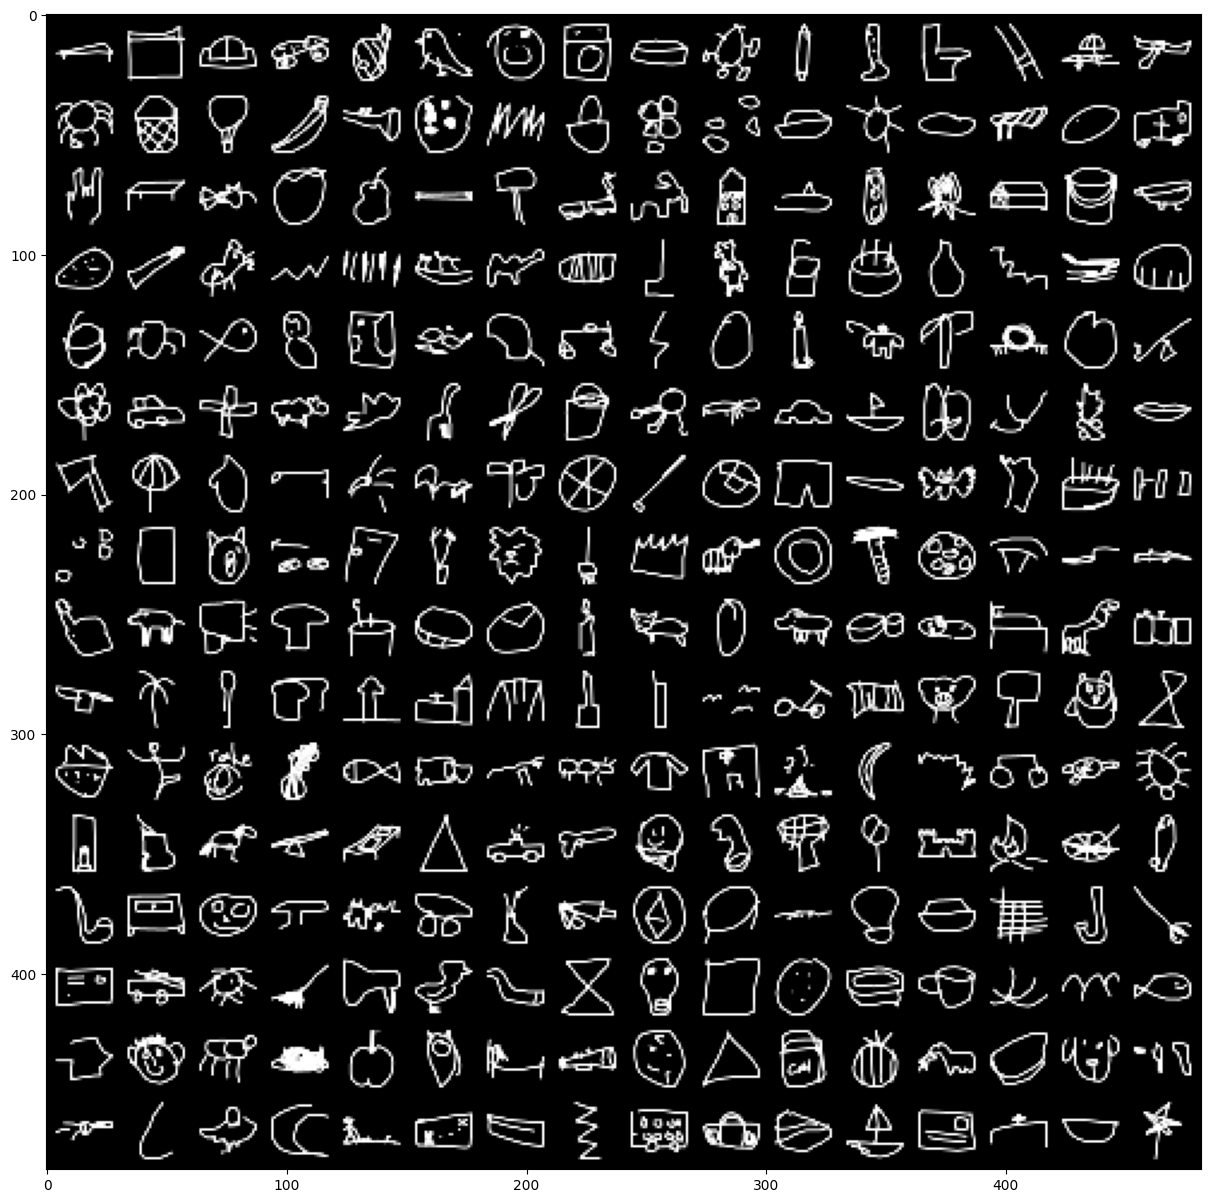

In [6]:
#print train_loader shape
images, labels = next(iter(train_loader))
print('Images shape on batch size = ', images.size())
print('Labels shape on batch size = ', labels.size())

#plot first batch of images
grid = torchvision.utils.make_grid(images, nrow=16)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels)
plt.show()



The `Network` class is created, which inherits the `torch.nn.Module` class. The class implements the convolutional neural network architecture. The architecture consists of 3 sets of layers made of 2 convolution layers, 1 max pool and also 1 batch normalization layer to improve performance. The last 3 layers are fully connected layers, which use dropout to prevent overfitting. The activation function used for the convolutional layers is the ReLU function.

In [7]:
#2
class Network(nn.Module):
    def __init__(self, in_size, out_size):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_size, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(512)
        
        self.fc1 = nn.Linear(512*3*3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, out_size)
        
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.batchnorm1(x)
        
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.batchnorm2(x)
        
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.pool(x)
        x = self.batchnorm3(x)
        
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

The hyperparameters are set, such as the learning rate and the number of epochs. The optimizer used is the `Adam` optimizer with weight decay. The loss function used is the `CrossEntropyLoss` function.

In [8]:
learning_rate = 1e-3
epochs = 10
category = 340

model = Network(1, category).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           4,640
              ReLU-4           [-1, 32, 28, 28]               0
         MaxPool2d-5           [-1, 32, 14, 14]               0
       BatchNorm2d-6           [-1, 32, 14, 14]              64
            Conv2d-7           [-1, 64, 14, 14]          18,496
              ReLU-8           [-1, 64, 14, 14]               0
            Conv2d-9          [-1, 128, 14, 14]          73,856
             ReLU-10          [-1, 128, 14, 14]               0
        MaxPool2d-11            [-1, 128, 7, 7]               0
      BatchNorm2d-12            [-1, 128, 7, 7]             256
           Conv2d-13            [-1, 256, 7, 7]         295,168
             ReLU-14            [-1, 25

This cell is used to load a previously trained model, if it exists, to continue training

In [36]:
#load existing model
path = 'models/best_model.pth'
model.load_state_dict(torch.load(path, map_location=device, weights_only=True))

<All keys matched successfully>

In the training loop, the model is trained on the training dataset and the loss is calculated. The model is then evaluated on the validation dataset. The model is saved if the validation loss is the lowest. The training and validation losses are printed at each epoch.

In [ ]:
def train(model, train_loader, valid_loader, epochs, criterion, optimizer, device):
    best_valid_loss = np.Inf
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(epochs):
        train_loss = 0
        valid_loss = 0
        train_accuracy = 0
        valid_accuracy = 0
        
        print(f"EPOCH {epoch+1}: ", end='')
        
        
        model.train()
        for image, label in train_loader:
            label = label.type(torch.LongTensor)
            image, label = image.to(device), label.to(device)
                
            optimizer.zero_grad()
            
            output = model(image)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_accuracy += (output.argmax(dim=1) == label).float().mean()
            
        print(f"Train loss: {train_loss/len(train_loader):.4f}, Train accuracy: {train_accuracy/len(train_loader):.4f}", end=' ')
        
        
        with torch.no_grad():
            model.eval()
            for image, label in valid_loader:
                label = label.type(torch.LongTensor)
                image, label = image.to(device), label.to(device)
                    
                output = model(image)
                loss = criterion(output, label)
                
                valid_loss += loss.item()
                valid_accuracy += (output.argmax(dim=1) == label).float().mean()
            
        print(f"Valid loss: {valid_loss/len(valid_loader):.4f}, Valid accuracy: {valid_accuracy/len(valid_loader):.4f}")
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print('Model saved')
            
        #append losses and accuracies for plotting
        train_losses.append(train_loss/len(train_loader))
        valid_losses.append(valid_loss/len(valid_loader))
        train_accuracies.append(train_accuracy/len(train_loader))
        valid_accuracies.append(valid_accuracy/len(valid_loader))
        
        train_losses = np.array(train_losses)
        valid_losses = np.array(valid_losses)
        train_accuracies = [x.cpu().detach().numpy() for x in train_accuracies]
        valid_accuracies = [x.cpu().detach().numpy() for x in valid_accuracies]


        #plot losses
        ax, fig = plt.subplots(1, 2, figsize=(15, 5))
        fig[0].plot(train_losses, label='Training loss')
        fig[0].plot(valid_losses, label='Validation loss')
        fig[0].set_title('Loss')
        fig[0].legend()

        fig[1].plot(train_accuracies, label='Training accuracy')
        fig[1].plot(valid_accuracies, label='Validation accuracy')
        fig[1].set_title('Accuracy')
        fig[1].legend()

        plt.show()
    
    
train(model, train_loader, valid_loader, epochs, criterion, optimizer, device)      

The model is evaluated on the test dataset and the accuracy is calculated. The confusion matrix is calculated and plotted. The classification report is printed, which contains the precision, recall and F1 score of the model.

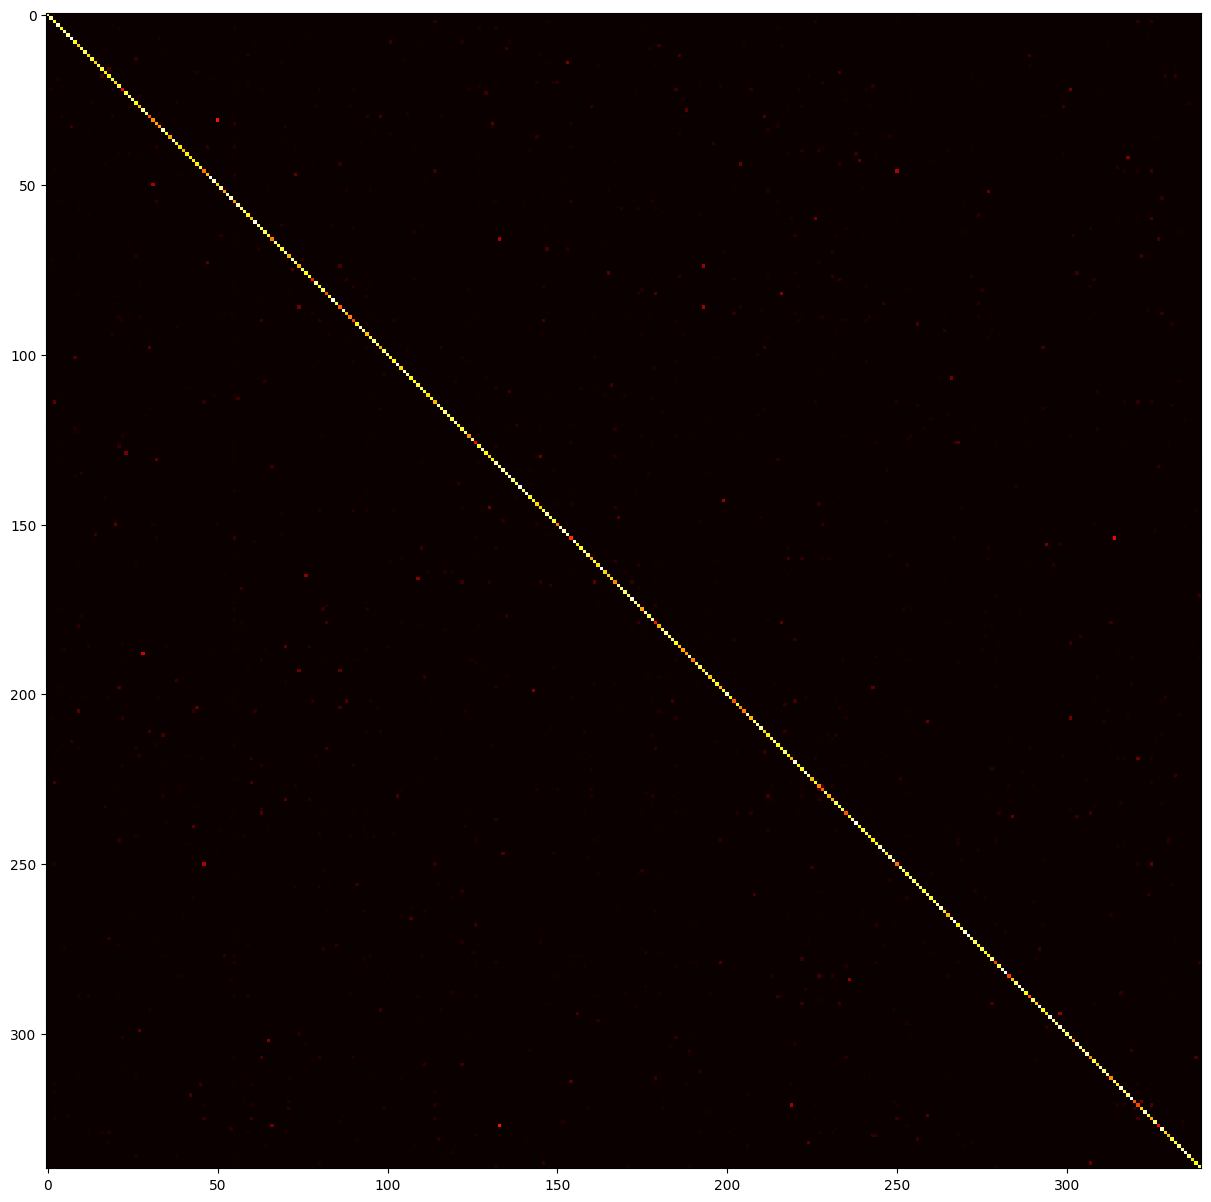

Accuracy: 0.7432
Precision: 0.7482
Recall: 0.7432
F1 score: 0.7426


In [11]:
model_path = 'models/best_model_30000_74%.pth'

#load best model
model = Network(1, 340).to(device)
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

#test the model
confusion_matrix = np.zeros((category, category))
with torch.no_grad():
    model.eval()
    for image, label in test_loader:
        label = label.type(torch.LongTensor)
        image, label = image.cuda(), label.cuda()    

        output = model(image)
        for i in range(len(label)):
            confusion_matrix[label[i], output[i].argmax().item()] += 1
        
    

#calculate confusion matrix
plt.figure(figsize=(15, 15))
plt.imshow(confusion_matrix, cmap='hot', interpolation='nearest')
plt.show()

#calculate accuracy, precision, recall and f1 score
test_accuracy = np.diag(confusion_matrix).sum() / confusion_matrix.sum()
precision = np.zeros(category)
recall = np.zeros(category)
f1 = np.zeros(category)
for i in range(category):
    precision[i] = confusion_matrix[i, i] / confusion_matrix[:, i].sum()
    recall[i] = confusion_matrix[i, i] / confusion_matrix[i, :].sum()
    f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
    
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision.mean():.4f}")
print(f"Recall: {recall.mean():.4f}")
print(f"F1 score: {f1.mean():.4f}")


Predictions are made on the test dataset to visualize the results.

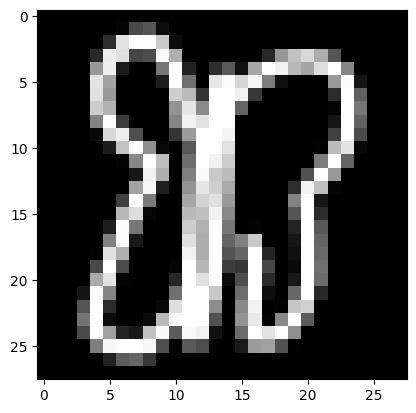

Predicted: butterfly, Actual: butterfly


In [15]:
#get a image from test set
image, label = next(iter(test_loader))
label = label.type(torch.LongTensor)
image, label = image.cuda(), label.cuda()
    
output = model(image)
predicted = output.argmax(dim=1)
#plot the image
plt.imshow(image[0].cpu().numpy().squeeze(), cmap='gray')
plt.show()

print(f'Predicted: {class_dict[str(predicted[0].item())]}, Actual: {class_dict[str(label[0].item())]}')